cnn을 활용한 MNIST dataset 분류기 만들기

In [1]:
import tensorflow as tf
from tensorflow.keras import datasets

import matplotlib.pyplot as plt

(X_train, y_train), (X_test, y_test) = datasets.mnist.load_data()

11490434/11490434 [==============================] - 2s 0us/step


(28, 28)


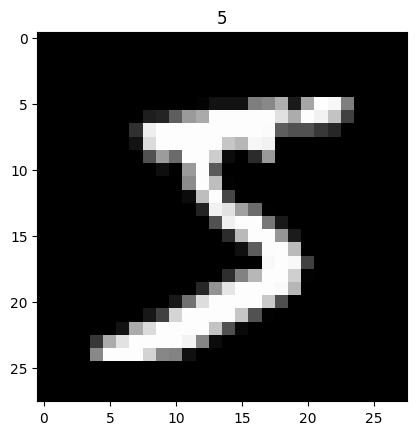

In [2]:
IMAGE_IDX = 0

image = X_train[IMAGE_IDX]
print(image.shape)

plt.imshow(image, cmap='gray')
plt.title(y_train[IMAGE_IDX])
plt.show()

## CNN 레이어에 입력하기 위한 배열 편집
- 반드시 CNN 레이어는 4차원 배열 형식을 활용
  - (H, W) -> (N, H, W, C) 배치, 높이, 가로, 채널

In [3]:
# (28,28) -> (1, 28, 28, 1) N H W C
image = image[tf.newaxis, ..., tf.newaxis] #강제로 차원수를 확장
image.shape

(1, 28, 28, 1)

# Conv 레이어 사용
Keras에는 대표적인 두 가지 Conv 레이어가 존재
- Conv2D
  - 필터가 움직이는 방향이 2방향(가로, 세로)
  - 이미지 분석을 위해서 사용하는 일반적인 합성곱 레이어
- Conv1D
  - 필터가 움직이는 방향이 1방향
  - 텍스트 분석을 위해 사용하는 레이어

## Conv2D 레이어 매개변수
- `filters` : 필터의 개수 ($C_{out}$)
- `kernel_size` : 커널의 크기($H_k, W_k$)
- `strides` : 몇 개의 픽셀을 스킵하면서 필터가 입력 특성 맵을 훑게 할지 결정
  - stride가 커지면 출력 특징 맵(Output Feature Map)의 크기가 줄어든다.
  - MaxPooling 기법보다 stride 크기를 늘려서 출력 특징 맵의 크기를 줄이는 것이 요즘 추세
- `padding` : 0으로 둘러쌓여진 패딩을 만들 것인지에 대한 설정
  - `VALID` : 패딩을 만들지 않겠다.(기본)
  - `SAME` : Input Feature Map과 Output Feature Map의 크기를 똑같이 만들어주는 패딩을 설정
- `activation` : 활성화 함수를 지정하는 옵션(선택 가능)

In [5]:
from tensorflow.keras.layers import Conv2D

layer = Conv2D(filters=5, #필터의 개수 -> Cout
               kernel_size = (3,3), # 커널의 세로, 가로 크기
               strides=1,
               padding='SAME')
#입력특징맵에 채널은 입력하지 않아도 됨

layer

In [9]:
#numpy array를 tensor로 변환
image = tf.cast(image, dtype=tf.float32)
image.shape

TensorShape([1, 28, 28, 1])

In [10]:
# 케라스의 레이어 객체는 함수처럼 사용할 수 있다.
conv_output = layer(image)
conv_output.shape
#output feature map

TensorShape([1, 28, 28, 5])

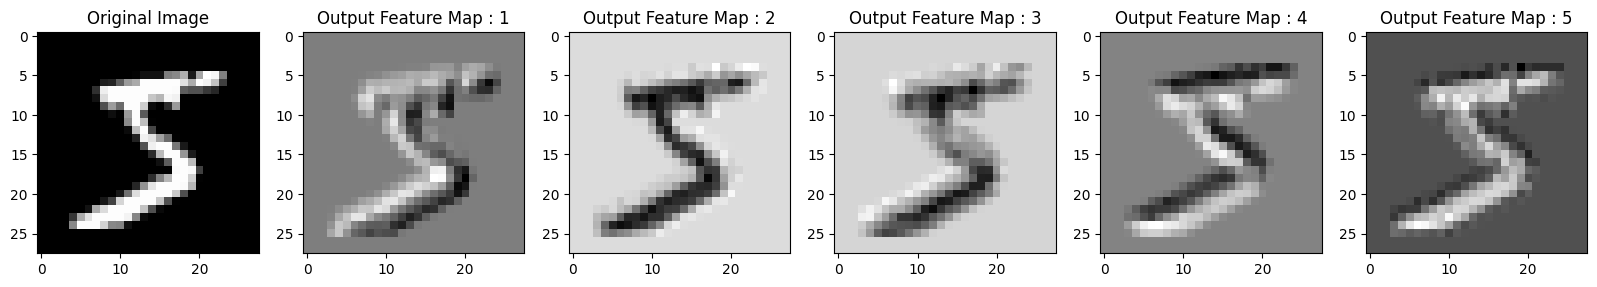

In [11]:
#output feature map 시각화 
_, axes = plt.subplots(nrows=1, ncols=6, figsize=(20, 10))

original_image = image[0, ..., 0]
axes[0].imshow(original_image, cmap='gray')
axes[0].set_title("Original Image")

output_features = conv_output[0]

for idx, ax in enumerate(axes[1:]):
  ax.imshow(output_features[..., idx], cmap='gray')
  ax.set_title("Output Feature Map : {}".format(idx + 1))

plt.show()

## Filter 시각화
- CNN에서 Filter는 가중치의 역할을 한다.
- 계산 가능한 레이어(학습 대상 레이어. Dense, Conv, LSTM RNN 등등..)에서는 가중치와 편향을 확인할 수 있다.
  - `get_weights()` 함수를 이용해서 가중치와 편향을 확인할 수 있다.

In [13]:
weights = layer.get_weights()
weights

[array([[[[-0.2598483 ,  0.17016247, -0.32085222,  0.05281505,
            0.07900676]],
 
         [[-0.01299486, -0.30976462, -0.2857635 ,  0.25175372,
           -0.21459477]],
 
         [[ 0.20746866, -0.24879146, -0.15763736,  0.01694265,
            0.21791998]]],
 
 
        [[[-0.09258907, -0.18825349,  0.13847771, -0.05377308,
            0.18147495]],
 
         [[ 0.06675896, -0.07643485, -0.04824725,  0.10483074,
            0.28277192]],
 
         [[ 0.02773905, -0.24140804, -0.02065992,  0.18954101,
            0.13571754]]],
 
 
        [[[-0.01109791,  0.01787958, -0.2831657 , -0.2959568 ,
           -0.26919755]],
 
         [[ 0.10772571,  0.23666248, -0.17926678, -0.0663549 ,
            0.25681725]],
 
         [[ 0.02328548, -0.18817465,  0.2770022 , -0.21545665,
           -0.22929001]]]], dtype=float32),
 array([0., 0., 0., 0., 0.], dtype=float32)]

In [14]:
# 필터(가중치)의 shape
weights[0].shape
#Hk Wk Cin Cout

(3, 3, 1, 5)

In [15]:
# 편향의 shape
weights[1].shape

(5,)

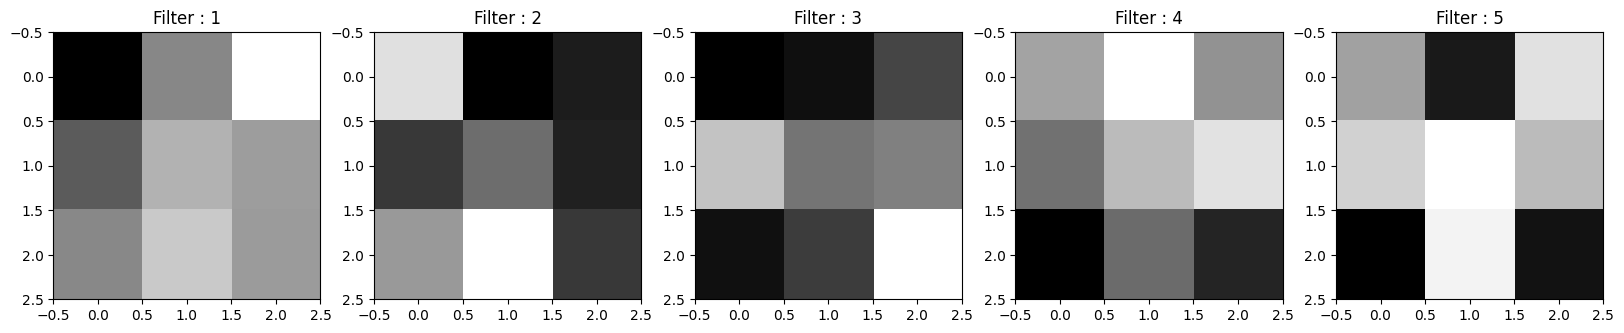

In [16]:
_, axes = plt.subplots(nrows=1, ncols=5, figsize=(20, 10))

for idx, ax in enumerate(axes):
  ax.set_title("Filter : {}".format(idx + 1))
  ax.imshow(weights[0][..., 0, idx], cmap='gray')

plt.show()

# ReLU 레이어 사용
- 이미지 분석에서 `ReLU`가 자주 사용된다.
- 이미지 데이터에서 음수 데이터는 필요가 없는 데이터
  - 필요 없는 음수 데이터는 제거하고, 이미지 픽셀에서 의미를 가지는 양수 데이터만 강조하기 위해 `ReLU`가 일반적으로 사용된다.
  - 최근에는 `ReLU`와 더불어 `Leakly ReLU`도 같이 사용된다.

In [17]:
import numpy as np
np.min(conv_output), np.max(conv_output)

(-281.08398, 172.01549)

In [18]:
from tensorflow.keras.layers import ReLU

act_layer = ReLU()
act_output = act_layer(conv_output)
act_output.shape

TensorShape([1, 28, 28, 5])

In [19]:
np.min(act_output), np.max(act_output)

(0.0, 172.01549)

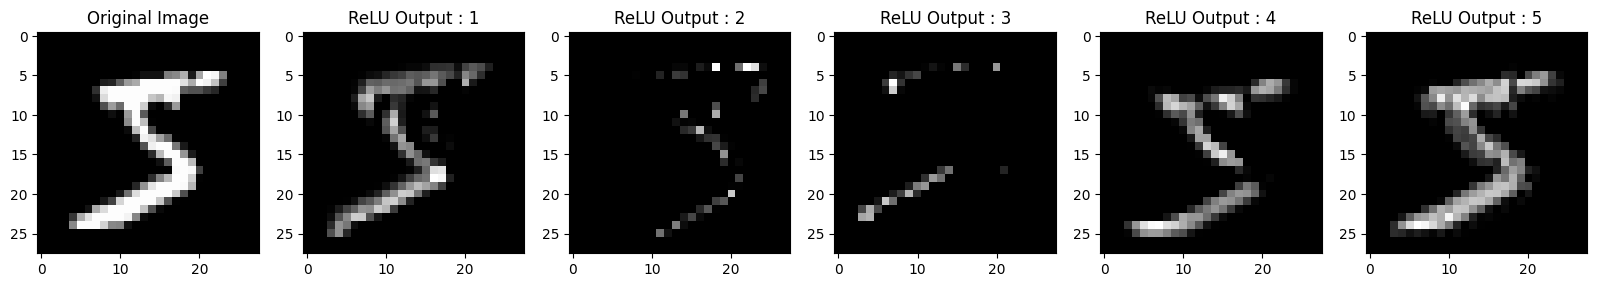

In [20]:
_, axes = plt.subplots(nrows=1, ncols=6, figsize=(20, 10))

axes[0].imshow(image[0, ..., 0], cmap='gray')
axes[0].set_title("Original Image")

for idx, ax in enumerate(axes[1:]):
  ax.set_title("ReLU Output : {}".format(idx + 1))
  ax.imshow(act_output[0, ..., idx], cmap='gray')

plt.show()

# MaxPooling
- 이미지 축소 및 정보의 종합을 구현
- 필요한 정보가 없어질 수도 있기 때문에 최근에는 Conv2D의 stride를 증가시키는 방법으로 이미지 축소를 구현한다.

In [21]:
from tensorflow.keras.layers import MaxPool2D

pool_layer = MaxPool2D(pool_size=2, strides=2)
pool_output = pool_layer(act_output)
pool_output.shape

TensorShape([1, 14, 14, 5])

MaxPooling 시각화

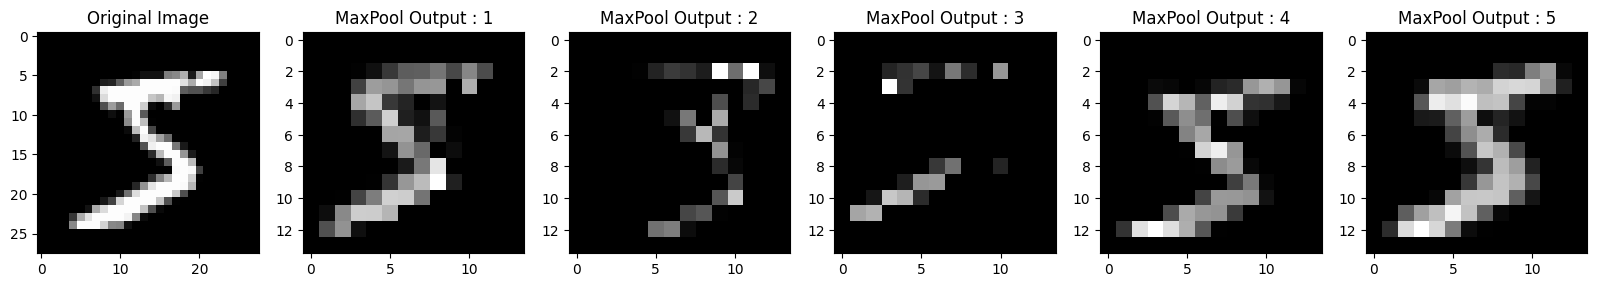

In [22]:
_, axes = plt.subplots(nrows=1, ncols=6, figsize=(20, 10))

axes[0].imshow(image[0, ..., 0], cmap='gray')
axes[0].set_title("Original Image")

for idx, ax in enumerate(axes[1:]):
  ax.set_title("MaxPool Output : {}".format(idx + 1))
  ax.imshow(pool_output[0, ..., idx], cmap='gray')

plt.show()


# Sequential Model 로 MNIST 분류기 만들기

In [25]:
from tensorflow.keras.models import Sequential # 모델
from tensorflow.keras.layers import Conv2D, ReLU, MaxPool2D # Feature Extraction
from tensorflow.keras.layers import Flatten, Dense, Input # Fully Connected

model = Sequential([Input(shape=(28, 28, 1)), # 배치 사이즈 제외한 크기
                    
                    ### Feature Extraction
                    Conv2D(filters=64, kernel_size=3, padding='SAME', activation='relu'),
                    Conv2D(filters=64, kernel_size=3, padding='SAME', activation='relu'),
                    MaxPool2D(pool_size=2, strides=2),

                    Conv2D(filters=32, kernel_size=3, padding='SAME', activation='relu'),
                    Conv2D(filters=32, kernel_size=3, padding='SAME', activation='relu'),
                    MaxPool2D(pool_size=2, strides=2),
                    # 7*7 32 채널 짜리 데이터 나옴

                    ### Fully Connected
                    Flatten(), #채널이 512개 이상인 경우에는 GlobalAveragePooling 사용
                    
                    #hidden layer
                    Dense(512, activation = 'relu'),
                    Dense(256, activation = 'relu'),
                    
                    #출력층
                    Dense(10, activation = 'softmax')
                    ])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 28, 28, 64)        640       
                                                                 
 conv2d_4 (Conv2D)           (None, 28, 28, 64)        36928     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 14, 14, 64)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 14, 14, 32)        18464     
                                                                 
 conv2d_6 (Conv2D)           (None, 14, 14, 32)        9248      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 7, 7, 32)         0         
 2D)                                                    

In [26]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import sparse_categorical_crossentropy

model.compile(
    optimizer=Adam(),
    loss = sparse_categorical_crossentropy,
    metrics=['acc']
)

history = model.fit(X_train, y_train,
                    batch_size=32,
                    epochs=20,
                    validation_split=0.20)

Epoch 1/20
1500/1500 [==============================] - 14s 5ms/step - loss: 0.1679 - acc: 0.9543 - val_loss: 0.0705 - val_acc: 0.9782
Epoch 2/20
1500/1500 [==============================] - 8s 6ms/step - loss: 0.0598 - acc: 0.9815 - val_loss: 0.0480 - val_acc: 0.9851
Epoch 3/20
1500/1500 [==============================] - 9s 6ms/step - loss: 0.0463 - acc: 0.9859 - val_loss: 0.0442 - val_acc: 0.9876
Epoch 4/20
1500/1500 [==============================] - 9s 6ms/step - loss: 0.0421 - acc: 0.9873 - val_loss: 0.0548 - val_acc: 0.9852
Epoch 5/20
1500/1500 [==============================] - 9s 6ms/step - loss: 0.0328 - acc: 0.9904 - val_loss: 0.0487 - val_acc: 0.9872
Epoch 6/20
1500/1500 [==============================] - 8s 6ms/step - loss: 0.0318 - acc: 0.9907 - val_loss: 0.0442 - val_acc: 0.9888
Epoch 7/20
1500/1500 [==============================] - 9s 6ms/step - loss: 0.0238 - acc: 0.9928 - val_loss: 0.0589 - val_acc: 0.9875
Epoch 8/20
1500/1500 [==============================] - 8s 5m